<a href="https://colab.research.google.com/github/Andarsan/price_car/blob/main/github_%D0%BE%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D1%81%D1%82%D0%BE%D0%B8%D0%BC%D0%BE%D1%81%D1%82%D0%B8_%D0%B0%D0%B2%D1%82%D0%BE%D0%BC%D0%BE%D0%B1%D0%B8%D0%BB%D0%B5%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [38]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import os
import numpy as np
import time
import copy
# модели
! pip install catboost
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
#import lightgbm as lgb
from lightgbm import LGBMRegressor
# метрика
from sklearn.metrics import mean_squared_error
# загружаем класс pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV,\
train_test_split,\
cross_val_score
# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, \
OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler

RANDOM_STATE=42
try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception as ex:
    template = "An exception of type {0} occurred. Arguments:\n{1!r}"
    message = template.format(type(ex).__name__, ex.args)
    print(message)
import matplotlib.pyplot as plt
import seaborn as sns
! pip install phik
# Вычисление матрицы корреляции с использованием phik
import phik


Defaulting to user installation because normal site-packages is not writeable
An exception of type ModuleNotFoundError occurred. Arguments:
("No module named 'google.colab'",)
Defaulting to user installation because normal site-packages is not writeable


In [39]:
pth1 = '/datasets'#/ferma_main.csv'
pth2 = '/content/drive/MyDrive/Colab Notebooks/all_project' #/ferma_main.csv'
pth3 = 'C:/Users/andar/Downloads'
if os.path.exists(pth1):
  pth = pth1
elif os.path.exists(pth2):
  pth = pth2
elif os.path.exists(pth3):
  pth = pth3
else:
  pth = 'Something is wrong'
display(f'рабочий каталог: {pth}')

'рабочий каталог: C:/Users/andar/Downloads'

In [40]:

def df_plt_describe(_df,_for,describe=False):
    for i in _for:
        j=0
        for _ in range(1):
            if _df[i].dtype != 'object':
                # Set up the plot
                ax = plt.subplot(2, 2, j + 1)
                j = j+1
                # Draw the plot
                ax.boxplot(_df[i])
                # Title and labels
                ax.set_title(i)
                ax = plt.subplot(2, 2, j + 1)
                j = j+1
                # Draw the plot
                ax.hist(_df[i])
                # Title and labels
                ax.set_title(i)
        plt.tight_layout()
        plt.show()
        plt.close()
    if describe:
        display(_df[_for].describe())


In [41]:
df = pd.read_csv(pth + '/autos.csv')
display(df.head(5))
display(df.info())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

In [42]:
df.columns =  [item.lower() for item in df.columns]

•	Название луче бы не трогал

In [43]:
df['datecrawled'].astype('datetime64[ns]').dt.year.unique()

array([2016])

In [44]:
df = df.drop(columns=['datecrawled',
                      'numberofpictures',
                      'datecreated',
                      'lastseen'])

•	Удалили лишние признаки

### 'vehicletype'

In [45]:
display(df['vehicletype'].isna().sum())
df.loc[df['vehicletype'].isna(), 'vehicletype'] = 'NaN'
display(df['vehicletype'].isna().sum())
display(df['vehicletype'].unique())

37490

0

array(['NaN', 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

•	Заменили все пропуски на ‘NaN’

### 'registrationyear'

In [46]:
df['registrationyear'].describe()

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registrationyear, dtype: float64

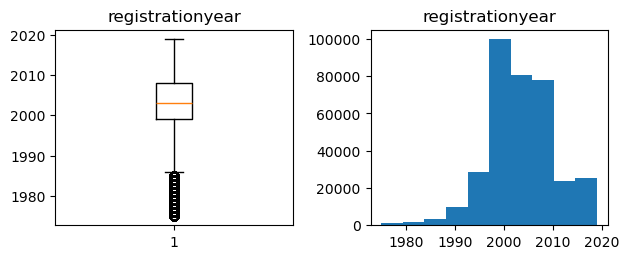

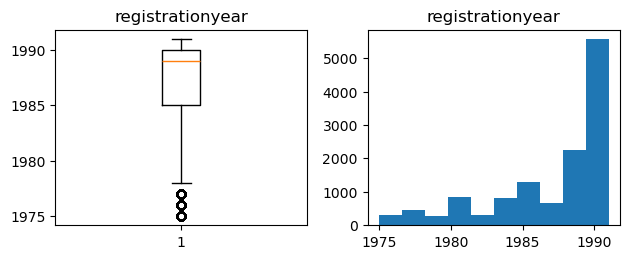

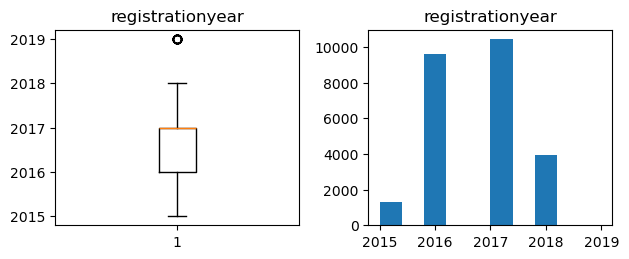

In [47]:
df_plt_describe(
    df.query('registrationyear >= 1975 and registrationyear <= 2024'),
    ['registrationyear'])
df_plt_describe(
    df.query('registrationyear >= 1975 and registrationyear <= 1991'),
    ['registrationyear'])
df_plt_describe(
    df.query('registrationyear >= 2015 and registrationyear <= 2020'),
    ['registrationyear'])


•	Оставим только период с 1900

In [48]:
df = df.query('registrationyear >= 1975')
where = df['registrationyear'] <= 1990
df.loc[where, 'old'] = 'супер-ретро'
where = (df['registrationyear'] > 1990) & (df['registrationyear'] <= 1999)
df.loc[where, 'old'] = 'ретро'
where = (df['registrationyear'] > 1999) & (df['registrationyear'] <= 2003)
df.loc[where, 'old'] = 'древняя'
where = (df['registrationyear'] > 2003) & (df['registrationyear'] <= 2008)
df.loc[where, 'old'] = 'старая'
where = df['registrationyear'] > 2008
df.loc[where, 'old'] = 'новая'
df.groupby('old')['old'].count()

old
древняя        83469
новая          74453
ретро          89778
старая         94194
супер-ретро    10082
Name: old, dtype: int64

### 'gearbox'

In [49]:
display(df['gearbox'].isna().sum())
display(df['gearbox'].unique())
df.loc[df['gearbox'].isna(), 'gearbox'] = 'NaN'
#df = df.query('gearbox == gearbox')
display(df['gearbox'].unique())

19181

array(['manual', 'auto', nan], dtype=object)

array(['manual', 'auto', 'NaN'], dtype=object)

•	Исключили те где пропуски

### 'power'

In [50]:
df['power'].describe()

count    351976.000000
mean        110.346322
std         188.289661
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

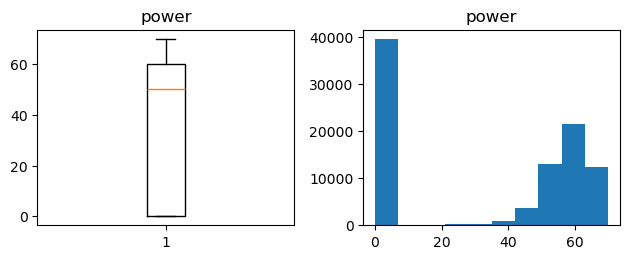

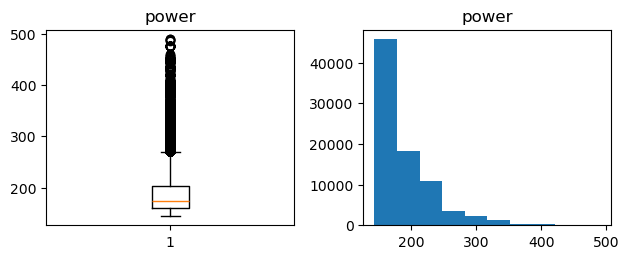

In [51]:
df_plt_describe(df.query('power < 71'),['power'])
df_plt_describe(df.query('power > 143 and power < 500'),['power'])

•	У кого меньше 40 сделаем 40 кроме 0 (оставим 0)

•	У кого больше 400 сделаем 400

In [52]:
df.loc[(df['power'] > 0) & (df['power']<40),'power'] = 40
df.loc[(df['power'] >= 400),'power'] = 400


•	Заменили все пропуски на ‘NaN’

### 'model'

In [53]:
display(df['model'].isna().sum())
df.loc[df['model'].isna(), 'model'] = 'NaN'

19010

•	Заменили все пропуски на ‘NaN’

### 'kilometer'

In [54]:
df['kilometer'].describe()

count    351976.000000
mean     128552.799054
std       37544.082564
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

### 'registrationmonth'

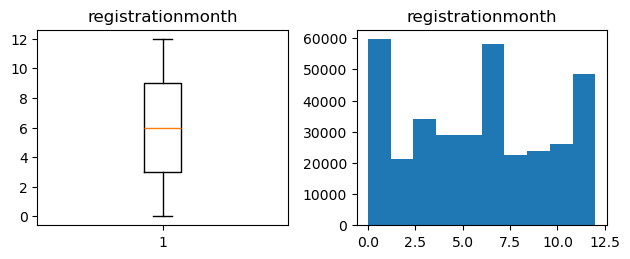

0

In [55]:
df_plt_describe(df,['registrationmonth'])
display(df['registrationmonth'].isna().sum())

### 'fueltype'

In [56]:
display(df['fueltype'].isna().sum())
df.loc[df['fueltype'].isna(), 'fueltype'] = 'NaN'
display(df['fueltype'].isna().sum())
display(df['fueltype'].unique())

32269

0

array(['petrol', 'gasoline', 'NaN', 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [57]:
df.loc[df['fueltype']=='gasoline', 'fueltype'] = 'petrol'
df.loc[df['fueltype']=='lpg', 'fueltype'] = 'cng'

•	Заменили все пропуски на ‘NaN’

### 'brand'

In [58]:
display(df['brand'].isna().sum())
display(sorted(df['brand'].unique()))

0

['alfa_romeo',
 'audi',
 'bmw',
 'chevrolet',
 'chrysler',
 'citroen',
 'dacia',
 'daewoo',
 'daihatsu',
 'fiat',
 'ford',
 'honda',
 'hyundai',
 'jaguar',
 'jeep',
 'kia',
 'lada',
 'lancia',
 'land_rover',
 'mazda',
 'mercedes_benz',
 'mini',
 'mitsubishi',
 'nissan',
 'opel',
 'peugeot',
 'porsche',
 'renault',
 'rover',
 'saab',
 'seat',
 'skoda',
 'smart',
 'sonstige_autos',
 'subaru',
 'suzuki',
 'toyota',
 'trabant',
 'volkswagen',
 'volvo']

### 'repaired'

In [59]:
display(df['repaired'].isna().sum())
#df = df.query('repaired == repaired')
df.loc[df['repaired']!=df['repaired'], 'repaired'] = 'NaN'
display(df['repaired'].isna().sum())
display(sorted(df['repaired'].unique()))

70251

0

['NaN', 'no', 'yes']

•	Это одна из важнейших но пришлось исключить те где пропуски

### 'postalcode'

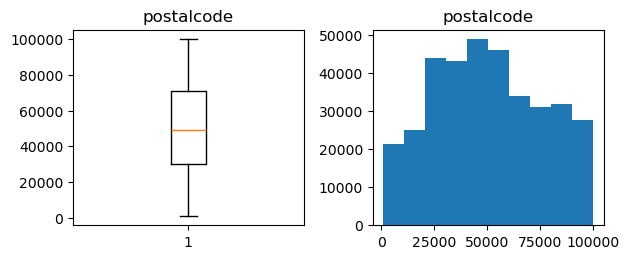

0

8142

In [60]:
df_plt_describe(df,['postalcode'])
display(df['postalcode'].isna().sum())
display(len(df['postalcode'].unique()))

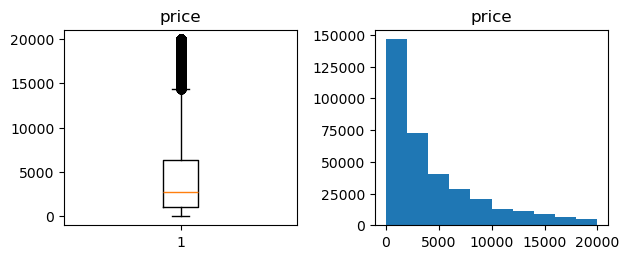

0

(10539,)

In [61]:
df_plt_describe(df,['price'])
display(df['price'].isna().sum())
display(df.loc[df['price']==0].shape[:1])
df = df.loc[df['price']!=0]

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 341437 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              341437 non-null  int64 
 1   vehicletype        341437 non-null  object
 2   registrationyear   341437 non-null  int64 
 3   gearbox            341437 non-null  object
 4   power              341437 non-null  int64 
 5   model              341437 non-null  object
 6   kilometer          341437 non-null  int64 
 7   registrationmonth  341437 non-null  int64 
 8   fueltype           341437 non-null  object
 9   brand              341437 non-null  object
 10  repaired           341437 non-null  object
 11  postalcode         341437 non-null  int64 
 12  old                341437 non-null  object
dtypes: int64(6), object(7)
memory usage: 36.5+ MB


Заключение:
* Исключил 6 признаков ['datecrawled',
                      'numberofpictures',
                      'datecreated',
                      'lastseen','postalcode','registrationmonth']
* VehicleType -  там где пусто записал строку NaN
* RegistrationYear – разбил на пять категорий и удалили из модели те у которых < 1990
* Gearbox - там где пусто записал строку NaN
* Power - укого меньше 40 сделаем 40 кроме 0 (оставим 0), у кого больше 400 * сделаем 400
* Model – там где пусто записал строку NaN
* FuelType – объединил 'gasoline' с 'fueltype' и 'lpg' с 'fueltype'
* Repaired - там где пусто записал строку NaN

* Всего удаленно 12 931 (4%) записей из 354368.



## Обучение моделей

### Визуализация матрицы корреляции

interval columns not set, guessing: ['price', 'registrationyear', 'power', 'kilometer', 'registrationmonth', 'postalcode']


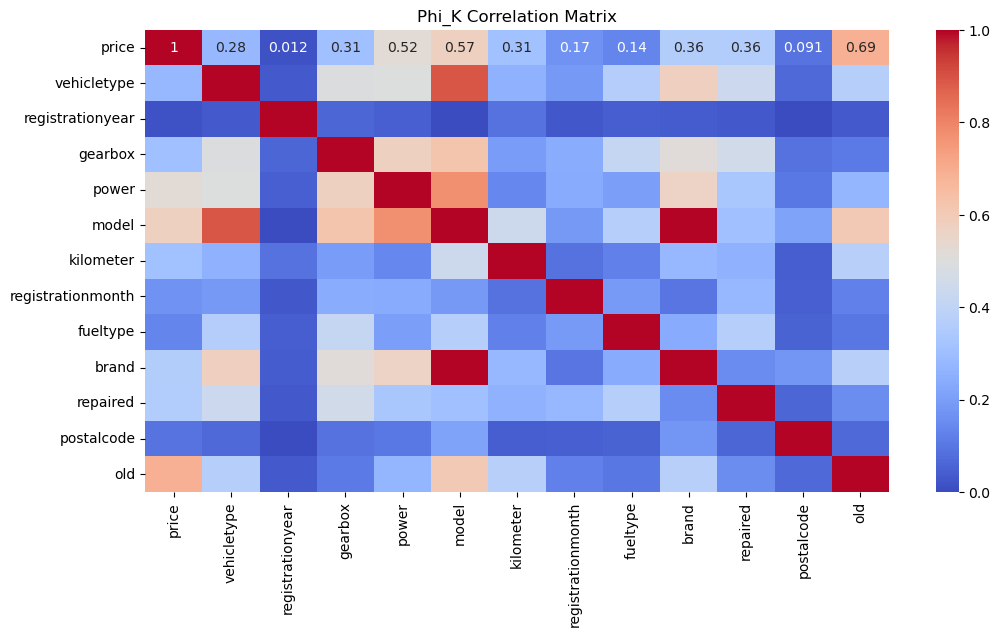

In [63]:
corr_matrix = df.phik_matrix()
plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

* очень высоких корреляций не видно, скорее всего мультиколлинеарности нет
* есть низкая корреляция у 'postalcode', удалим из модели

In [64]:
df = df.drop(columns=['postalcode','registrationmonth'])

### Pipeline

In [65]:
# извлечём четверть для онализа качества
test_features_valid = df.sample(frac=0.25, replace=False, random_state=RANDOM_STATE)

# целевой признак для онализа лутчей модели
test_valid = test_features_valid.price
# тестовый набор данных для анализа лучей модели
test_features_valid = test_features_valid.drop('price', axis=1)

# удалим эту четверть из обучения
df = df.drop(index = test_valid.index)
display(f'После извлечения из df : {df.shape[:1]}' )

'После извлечения из df : (256078,)'

In [66]:
# списки с названиями колонок

ord_columns = ['gearbox','fueltype', 'repaired',
               'vehicletype','model', 'brand','old']

num_columns = ['registrationyear','power','kilometer']

features_train, features_valid, target_train, target_valid = train_test_split(
    df.drop('price', axis=1), df.price, test_size=0.25, random_state=42)

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan,
                                                strategy='most_frequent')),
     ('ord',  OrdinalEncoder(handle_unknown='use_encoded_value',
                             unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])
data_preprocessor.fit_transform(features_valid).shape

(64020, 10)

#### DecisionTreeRegressor

In [67]:
%%time
param_grid = [{
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(6,7),
        'models__max_features': range(5,6),
        'models__min_samples_split': range(5,6),
        'models__min_samples_leaf': range(9,10),
        'preprocessor__num': [ MinMaxScaler(), 'passthrough']
}]

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=2,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    error_score='raise',
    random_state=RANDOM_STATE
)
# игнорируем сообщения перед обучением
warnings.filterwarnings('ignore')

# обучим модель с учителем
randomized_search.fit(features_train, target_train)

best_model = randomized_search.best_estimator_.named_steps['models']
display(f'Лучшая модель : {best_model}')

# попробуем предсказать
y_pred = randomized_search.best_estimator_.predict(features_valid)

# расчитаем метрику RMSE
display(mean_squared_error(target_valid, y_pred, squared=False))


'Лучшая модель : DecisionTreeRegressor(max_depth=6, max_features=5, min_samples_leaf=9,\n                      min_samples_split=5, random_state=42)'

2376.6925708063004

CPU times: total: 469 ms
Wall time: 1.22 s


#### CatBoostRegressor

In [68]:
%%time
param_grid = [
    {
        'models': [CatBoostRegressor(silent=True, iterations=5) ],
        'preprocessor__num': [MinMaxScaler(), 'passthrough']
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=2,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    error_score='raise',
    random_state=RANDOM_STATE
)
# обучим модель с учителем y
randomized_search.fit(features_train, target_train)
best_model = randomized_search.best_estimator_.named_steps['models']
display(f'Лучшая модель : {best_model}')
# попробуем предсказать
y_pred = randomized_search.best_estimator_.predict(features_valid)
display(mean_squared_error(target_valid, y_pred, squared=False))

'Лучшая модель : <catboost.core.CatBoostRegressor object at 0x000001F1CA5F2750>'

2181.9539747866124

CPU times: total: 781 ms
Wall time: 2.41 s


#### LGBMRegressor

In [69]:
%%time
param_grid = [
    {
        'models': [LGBMRegressor()],
        'models__num_leaves': range(23,24),
        'models__max_depth': range(23,24),
        'preprocessor__num': [ MinMaxScaler(), 'passthrough']
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=10,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    error_score='raise',
    random_state=RANDOM_STATE
)

randomized_search.fit(features_train, target_train)
best_model = randomized_search.best_estimator_.named_steps['models']
display(f'Лучшая модель : {best_model}')
y_pred = randomized_search.best_estimator_.predict(features_valid)
display(mean_squared_error(target_valid, y_pred, squared=False))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 574
[LightGBM] [Info] Number of data points in the train set: 192058, number of used features: 10
[LightGBM] [Info] Start training from score 4531.742635


'Лучшая модель : LGBMRegressor(max_depth=23, num_leaves=23)'

1789.2556141204886

CPU times: total: 3.83 s
Wall time: 4.64 s


## Анализ моделей

### Время DecisionTreeRegressor

•	Повторно натренируем модель на летучих параметрах и проведём анализ качества

In [70]:
# трансформируем тренировочные и тестовые данные

X_train = data_preprocessor.transform(features_train)
X_valid = data_preprocessor.transform(features_valid)

model = DecisionTreeRegressor(max_depth=6,
                              max_features=5,
                              min_samples_leaf=9,
                              min_samples_split=5,
                              random_state=42)
# фиксируем время старта работы кода
start = time.time()
model.fit(X_train,target_train)
display('Время работы fit: ' + str(time.time() - start))
# фиксируем время старта работы кода
start = time.time()
y_pred = model.predict(X_valid)
display('Время работы predict: ' + str(time.time() - start))
display(mean_squared_error(target_valid, y_pred, squared=False))
# фиксируем время старта работы кода
start = time.time()
display(f'SMAPE на кросс-валидации :{cross_val_score(model,X_valid,target_valid,cv=5,scoring = "neg_root_mean_squared_error").mean()*-1}')
display('Время работы кросс-валидации: ' + str(time.time() - start))

'Время работы fit: 0.07442903518676758'

'Время работы predict: 0.0029973983764648438'

2376.683310051152

'SMAPE на кросс-валидации :2434.9271495793487'

'Время работы кросс-валидации: 0.11438679695129395'

### Время CatBoostRegressor

•	Повторно натренируем модель и проведём анализ качества

In [71]:
# трансформируем тренировочные и тестовые данные
X_train = data_preprocessor.transform(features_train)
X_valid = data_preprocessor.transform(features_valid)

model = CatBoostRegressor(silent=True, iterations=5)
# фиксируем время старта работы кода
start = time.time()
model.fit(X_train,target_train)
display('Время работы fit: ' + str(time.time() - start))
# фиксируем время старта работы кода
start = time.time()
y_pred = model.predict(X_valid)
display('Время работы predict: ' + str(time.time() - start))
display(mean_squared_error(target_valid, y_pred, squared=False))
# фиксируем время старта работы кода
start = time.time()
display(f'SMAPE на кросс-валидации :{cross_val_score(model,X_valid,target_valid,cv=5,scoring = "neg_root_mean_squared_error").mean()*-1}')
display('Время работы кросс-валидации: ' + str(time.time() - start))

'Время работы fit: 0.2964186668395996'

'Время работы predict: 0.07352542877197266'

2171.170626611968

'SMAPE на кросс-валидации :2209.514831549228'

'Время работы кросс-валидации: 0.6198382377624512'

### Время LGBMRegressor

•	Повторно натренируем модель на летучих параметрах и проведём анализ качествен

In [72]:
# трансформируем тренировочные и тестовые данные

X_train = data_preprocessor.transform(features_train)
X_valid = data_preprocessor.transform(features_valid)

model = LGBMRegressor(num_leaves = 24, max_depth = 24)
# фиксируем время старта работы кода
start = time.time()
model.fit(X_train,target_train)
display('Время работы fit: ' + str(time.time() - start))
# фиксируем время старта работы кода
start = time.time()
y_pred = model.predict(X_valid)
display('Время работы predict: ' + str(time.time() - start))
display(mean_squared_error(target_valid, y_pred, squared=False))
# фиксируем время старта работы кода
start = time.time()
display(f'SMAPE на кросс-валидации :{cross_val_score(model,X_valid,target_valid,cv=5,scoring = "neg_root_mean_squared_error").mean()*-1}')
display('Время работы кросс-валидации: ' + str(time.time() - start))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 572
[LightGBM] [Info] Number of data points in the train set: 192058, number of used features: 10
[LightGBM] [Info] Start training from score 4531.742635


'Время работы fit: 0.19045376777648926'

'Время работы predict: 0.01500082015991211'

1783.8872865540573

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 559
[LightGBM] [Info] Number of data points in the train set: 51216, number of used features: 10
[LightGBM] [Info] Start training from score 4503.708470
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 51216, number of used features: 10
[LightGBM] [Info] Start training from score 4516.633630
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

'SMAPE на кросс-валидации :1808.356050121536'

'Время работы кросс-валидации: 0.4597764015197754'

### Тест лучей модели

In [73]:
# набор данных извлечённый из df перед обучением моделий
#(см. Pipeline)

X_valid = data_preprocessor.transform(test_features_valid)

# фиксируем время старта работы кода
start = time.time()
y_pred = model.predict(X_valid)
display('Время работы predict: ' + str(time.time() - start))
display(mean_squared_error(test_valid, y_pred, squared=False))

'Время работы predict: 0.0189971923828125'

1773.1318324211827

**Вывод:**


* **Здесь представлено решение, которое опробовало несколько моделей предсказание стоимости автомобиля**

- была представлена информация о 354368 автомобилей об их характеристиках и рыночной стоимости.

- данные небыли корректны  и были пропуски.

- часть данных была удалена часть дополнена.

- для поиска лучшей модели использовал конвейер Pipeline который позволил автоматизировать действия по подготовке данных, обучению моделей и оценке их качества.
                   
* **В итоге можно порекомендовать модель LGBMRegressor у неё самый лутчий показатель точности и приемлемая скорость.**


In [74]:
'end'

'end'